In [1]:
import numpy as np
import torch 
import os 
import pandas as pd 
from matplotlib import pyplot as plt
import networkx as nx
from scipy.stats import ranksums

os.chdir('/storage/coda1/p-ff14/0/msethuraman7/projects_murali/nodags-flows')
print("Currently in {}".format(os.getcwd()))

from models.resblock_trainer import resflow_train_test_wrapper

Currently in /storage/coda1/p-ff14/0/msethuraman7/projects_murali/nodags-flows


In [27]:
intervention_sets = np.load("../datasets_nodags/perturb_cite_seq_data/nodags_data/cocult/training_data/intervention_sets.npy", allow_pickle=True)
datasets = [np.load("../datasets_nodags/perturb_cite_seq_data/nodags_data/cocult/training_data/dataset_{}.npy".format(t)) for t in range(len(intervention_sets))]

In [28]:
valid_intervention_sets = np.load("../datasets_nodags/perturb_cite_seq_data/nodags_data/cocult/validation_data/intervention_sets.npy", allow_pickle=True)
valid_datasets = [np.load("../datasets_nodags/perturb_cite_seq_data/nodags_data/cocult/validation_data/dataset_{}.npy".format(t)) for t in range(len(valid_intervention_sets))]

In [29]:
training_datasets = datasets
training_interventions = intervention_sets

# validation_datasets = datasets[-6:]
# validation_interventions = intervention_sets[-6:]

total_data = 0

for data in training_datasets:
    total_data += len(data)

print(total_data)

11024


In [30]:
import scanpy as sc
import scipy.sparse as sp

adata = sc.read_h5ad("../datasets_nodags/perturb_cite_seq_data/SCP1064/ready/cocult/gene_filtered_adata.h5ad")
data = sp.csr_matrix.toarray(adata.X)

genes = adata.var.index

In [31]:
obs_data = data[adata.obs['targets'] == '',:]
obs_data_mu = obs_data.mean(axis=0)

# obs_data_mu

# Center the data with obs_data_mean
training_data_cent = [td - obs_data_mu for td in training_datasets]

In [32]:
nodags_wrapper = resflow_train_test_wrapper(
        n_nodes=61,
        batch_size=64,
        l1_reg=True,
        lambda_c=1e-3,
        n_lip_iter=5,
        fun_type='gst-mlp',
        act_fun='relu',
        epochs=100,
        lr=1e-2,
        lip_const=0.99,
        optim='adam',
        inline=True,
        n_hidden=0,
        lin_logdet=False,
        dag_input=False,
        thresh_val=0.05,
        upd_lip=True,
        centered=True)


Initializing the model
Number of Parameters : 7505


In [33]:
nodags_wrapper.train(training_data_cent, training_interventions, batch_size=256)

Starting Training


<IPython.core.display.Javascript object>


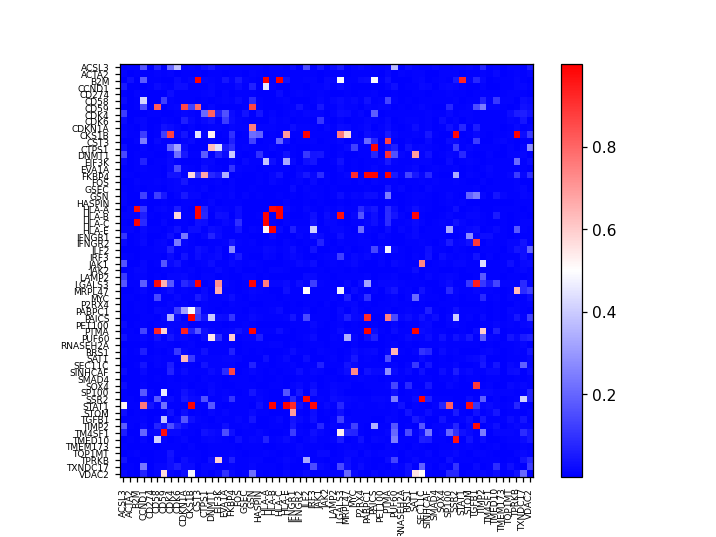

In [34]:
%matplotlib notebook

fig, axs = plt.subplots(1)

im = axs.imshow(nodags_wrapper.get_adjacency(), cmap='bwr')
axs.set_xticks(range(61))
axs.set_xticklabels(genes, rotation=90, size='xx-small')
axs.set_yticks(range(61))
axs.set_yticklabels(genes, size='xx-small')

cbar = plt.colorbar(im)

In [35]:
np.save("notebooks/adjacency_matrices_perturb_cite_seq/cocult.npy", nodags_wrapper.get_adjacency())

In [24]:
import seaborn

In [25]:
import pandas as pd

df = pd.DataFrame(columns=genes)
for i in range(61):
    df[genes[i]] = nodags_wrapper.get_adjacency()[:,i]

df.index = genes

<IPython.core.display.Javascript object>


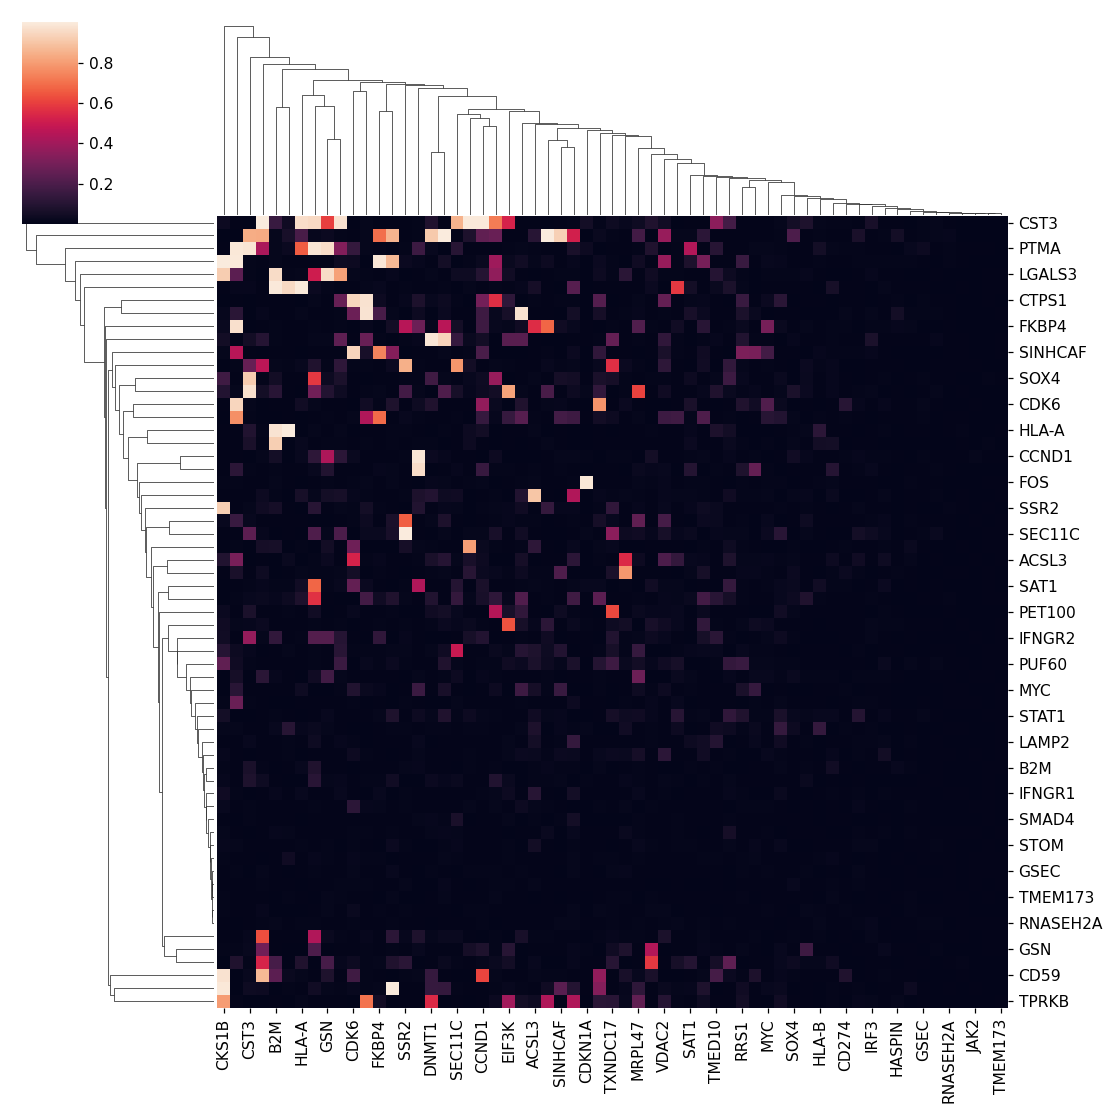

In [26]:
seaborn.clustermap(df)
# plt.savefig('cluster_map_ifn.pdf')

In [18]:
val_nll = nodags_wrapper.predictLikelihood(validation_data_cent, valid_intervention_sets)

print(np.mean(val_nll))

1.380757962419687


In [19]:
predictions = nodags_wrapper.forwardPass(validation_data_cent)

In [20]:
np.mean([np.abs(data - pred).mean(axis=0) for data, pred in zip(validation_data_cent, predictions)])

0.8450183351043595